# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, isnull, lag, lead, approx_count_distinct
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F 
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
df = spark.read.json("mini_sparkify_event_data.json")

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.count(), len(df.columns)

(286500, 18)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [73]:
df.take(10)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [10]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

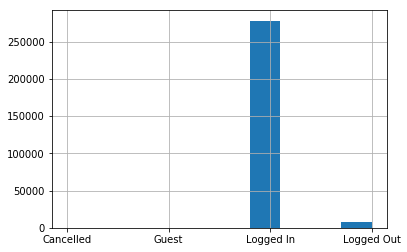

In [75]:
# visualize
df.select("auth").toPandas()['auth'].hist()

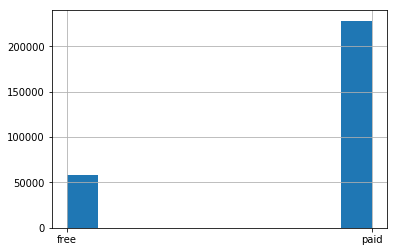

In [76]:
df.select("level").toPandas()['level'].hist() 

In [33]:
print(df.select('userId').distinct().filter(df.gender == 'M').count())
print(df.select('userId').distinct().filter(df.gender == 'F').count())


121
104


<AxesSubplot:title={'center':'Gender distribution'}>

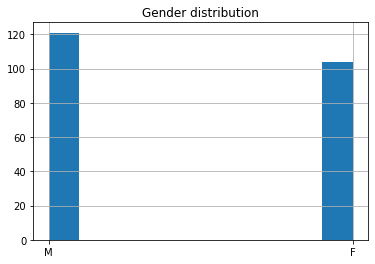

In [34]:
df_gender = df.select(["userId", "gender"]).toPandas().groupby(['userId'])['gender'].first()
plt.title('Gender distribution')
df_gender.hist()

In [78]:
df.filter(df.auth == 'Logged In').count()

278102

In [79]:
df.filter(df.auth == 'Cancelled').count()

52

In [151]:
df.filter(df.auth == 'Cancelled').head(5)

[Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', hour='4', session_activities=11, sessions=1, last_activity=None, session_end=1539318918000, session_start=1539317144000, session_length=1774, listening=0, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0, downgraded=1, churn=1),
 Row(artist=None, auth='Cancelled', firstName='Ethan', gender='M', itemInSession=176, lastName='Johnson', length=None, level='paid', location='Lexington-Fayette, KY', method='GET', page='Cancellation Confirmation', registration=1538080987000, sessionId=934, song=None, status=200, ts=1539761972000, userAgent

In [36]:
df.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [37]:
print(df.select('page').distinct().count())
df.select('page').distinct().show()

22
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [83]:
# Activities spent per session
df.select('itemInSession').describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [84]:
df.select('userAgent').distinct().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|                null|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



In [85]:
# distinct userIds
df.select('userId').distinct().count()

226

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5acad3c160>]], dtype=object)

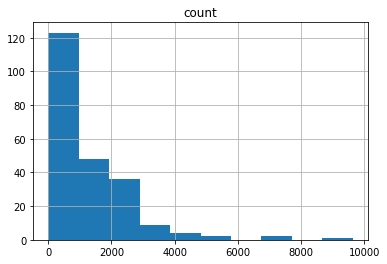

In [92]:
# activies per user
user_activity = df.groupBy('userId').count().toPandas()
user_activity.hist()

### Clean Data

In [87]:
# Check empty userId
df.filter(df['userId'] == '').count()

8346

In [88]:
# drop empty userIds
df = df.filter(df['userId'] != '')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [93]:
# Average action per user
user_activity['count'].describe()

count     225.000000
mean     1236.240000
std      1329.531716
min         6.000000
25%       296.000000
50%       848.000000
75%      1863.000000
max      9632.000000
Name: count, dtype: float64

In [39]:
125 * (24 * 60 * 60/55) * 0.9

176727.27272727274

In [94]:
# Total activies in each session use per user
window_session = Window.partitionBy([col("userId"), col("sessionId")])
df = df.withColumn("session_activities", count(col('ts')).over(window_session))
df.head(5)

[Row(artist=None, auth='Logged In', firstName='Alex', gender='M', itemInSession=2, lastName='Hogan', length=None, level='paid', location='Denver-Aurora-Lakewood, CO', method='GET', page='Home', registration=1535066380000, sessionId=635, song=None, status=200, ts=1539065365000, userAgent='Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='101', hour='6', session_activities=855),
 Row(artist=None, auth='Logged In', firstName='Alex', gender='M', itemInSession=3, lastName='Hogan', length=None, level='paid', location='Denver-Aurora-Lakewood, CO', method='PUT', page='Add Friend', registration=1535066380000, sessionId=635, song=None, status=307, ts=1539065366000, userAgent='Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='101', hour='6', session_activities=855),
 Row(artist=None, auth='Logged In', firstName='Alex', gender='M', itemInSession=4, lastName='Hogan', length=None, level='paid', location='Denver-Aurora-Lakewood, CO', m

In [95]:
# Total sessions number
window_user = Window.partitionBy("userId")
df = df.withColumn("sessions", approx_count_distinct(col('sessionId')).over(window_user))
df.head(5)

[Row(artist='Candlebox', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=299.72853, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=174, song='Far Behind  (Album Version)', status=200, ts=1541731560000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='2', session_activities=112, sessions=7),
 Row(artist='Bebe', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=225.77587, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=174, song='Men SeÃ\x83Â±arÃ\x83Â¡', status=200, ts=1541731859000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/1

In [96]:
window = Window.partitionBy('userId').orderBy('ts')
df = df.withColumn("last_activity", lead(col("ts"), 1).over(window))

In [99]:
# custom function to calcalate time difference in seconds between two timestamps 
calc_time_diff = udf(lambda t1, t2: 
                     abs(datetime.datetime.fromtimestamp(t1 / 1000.0) - datetime.datetime.fromtimestamp(t2 / 1000.0)).seconds)

In [100]:
# Calc Session Time for each session
df = df.withColumn("session_end", F.max(col('ts')).over(window_session))
df = df.withColumn("session_start", F.min(col('ts')).over(window_session))
df = df.withColumn("session_length", calc_time_diff(col('session_end'), col("session_start")).cast("int"))
df.head(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='12', session_activities=40, sessions=7, last_activity=1539003736000, session_end=1539010247000, session_start=1539003534000, session_length=6713),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=

In [101]:
listening_music = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
# Calc total songs listened per user
df = df.withColumn("listening", listening_music(col('page')))
df = df.withColumn("songs_listend", F.sum(col('listening')).over(window_user))
df.head(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='12', session_activities=40, sessions=7, last_activity=1539003736000, session_end=1539010247000, session_start=1539003534000, session_length=6713, listening=1, songs_listend=275),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beauti

In [102]:
# Average session length
df = df.withColumn('avg_session_length', avg(col('session_length')).over(window_user))
# Average songs listened session
df = df.withColumn('avg_songs_per_session', col('songs_listend')/col('sessions'))

In [103]:
df.select(['userId', 'ts', 'last_activity', 'sessionId', 'session_start', 
           'session_end', 'session_length','sessions', 'session_activities',
           'songs_listend', 'avg_session_length', 'avg_songs_per_session']).where(df.userId == "125").collect()

[Row(userId='125', ts=1539317144000, last_activity=1539317481000, sessionId=174, session_start=1539317144000, session_end=1539318918000, session_length=1774, sessions=1, session_activities=11, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0),
 Row(userId='125', ts=1539317481000, last_activity=1539317711000, sessionId=174, session_start=1539317144000, session_end=1539318918000, session_length=1774, sessions=1, session_activities=11, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0),
 Row(userId='125', ts=1539317711000, last_activity=1539317914000, sessionId=174, session_start=1539317144000, session_end=1539318918000, session_length=1774, sessions=1, session_activities=11, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0),
 Row(userId='125', ts=1539317914000, last_activity=1539318124000, sessionId=174, session_start=1539317144000, session_end=1539318918000, session_length=1774, sessions=1, session_activities=11, songs_listen

In [104]:
# Churn event
flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [105]:
# Get churn event
df = df.withColumn("downgraded", flag_downgrade_event("page"))
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='12', session_activities=40, sessions=7, last_activity=1539003736000, session_end=1539010247000, session_start=1539003534000, session_length=6713, listening=1, songs_listend=275, avg_session_length=12203.010498687665, avg_songs_per_session=39.285714285714285, downgraded=0)

In [106]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("downgraded").over(windowval))
df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='18', session_activities=33, sessions=7, last_activity=None, session_end=1542823952000, session_start=1542818132000, session_length=5820, listening=0, songs_listend=275, avg_session_length=12203.010498687665, avg_songs_per_session=39.285714285714285, downgraded=0, churn=0)

In [107]:
# check churn stats
df.dropDuplicates(['userId']).select(['userId', 'churn']).groupby('churn').count().collect()

[Row(churn=0, count=173), Row(churn=1, count=52)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [148]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import DecisionTreeClassifier

In [109]:
df_final = df.select(['userId','sessions', 'songs_listend',
                      'avg_session_length', 'avg_songs_per_session', 'churn']).dropDuplicates()
df_final.take(5)

[Row(userId='100010', sessions=7, songs_listend=275, avg_session_length=12203.010498687665, avg_songs_per_session=39.285714285714285, churn=0),
 Row(userId='200002', sessions=6, songs_listend=387, avg_session_length=24320.852320675105, avg_songs_per_session=64.5, churn=0),
 Row(userId='125', sessions=1, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0, churn=1),
 Row(userId='124', sessions=30, songs_listend=4079, avg_session_length=31024.511917098447, avg_songs_per_session=135.96666666666667, churn=0),
 Row(userId='51', sessions=10, songs_listend=2111, avg_session_length=30557.145698051947, avg_songs_per_session=211.1, churn=1)]

In [110]:
features = ['sessions', 'songs_listend', 'avg_session_length', 'avg_songs_per_session']
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_final = assembler.transform(df_final)
df_final.take(5)

[Row(userId='100010', sessions=7, songs_listend=275, avg_session_length=12203.010498687665, avg_songs_per_session=39.285714285714285, churn=0, features=DenseVector([7.0, 275.0, 12203.0105, 39.2857])),
 Row(userId='200002', sessions=6, songs_listend=387, avg_session_length=24320.852320675105, avg_songs_per_session=64.5, churn=0, features=DenseVector([6.0, 387.0, 24320.8523, 64.5])),
 Row(userId='125', sessions=1, songs_listend=8, avg_session_length=1774.0, avg_songs_per_session=8.0, churn=1, features=DenseVector([1.0, 8.0, 1774.0, 8.0])),
 Row(userId='124', sessions=30, songs_listend=4079, avg_session_length=31024.511917098447, avg_songs_per_session=135.96666666666667, churn=0, features=DenseVector([30.0, 4079.0, 31024.5119, 135.9667])),
 Row(userId='51', sessions=10, songs_listend=2111, avg_session_length=30557.145698051947, avg_songs_per_session=211.1, churn=1, features=DenseVector([10.0, 2111.0, 30557.1457, 211.1]))]

In [111]:
train, test = df_final.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 191
Test Dataset Count: 34


### Logistic Regression

In [112]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churn', maxIter=10)
lrModel = lr.fit(train)

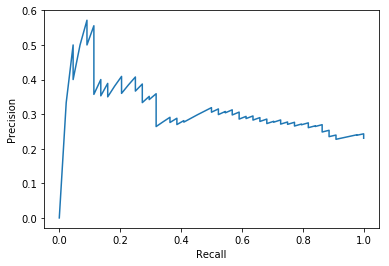

In [118]:
trainingSummary = lrModel.summary
pr = trainingSummary.pr.toPandas()b
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [149]:
pred = lrModel.transform(test)
TP = pred.filter(pred.churn == pred.prediction).count()
total = test.count()
print('accuracy for logistic regression is', TP/total)

accuracy for logistic regression is 0.7647058823529411


### Decision Tree Classifier

In [40]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'churn', maxDepth = 3)
dtModel = dt.fit(train)
pred = dtModel.transform(test)
TP = pred.filter(pred.churn == pred.prediction).count()
total = test.count()
print('accuracy for decsion tree is', TP/total)

accuracy for decsion tree is 0.7941176470588235


### Random Forest Classifier

In [147]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn')
rfModel = rf.fit(train)
pred = rfModel.transform(test)
TP = pred.filter(pred.churn == pred.prediction).count()
total = test.count()
print('accuracy for ramdom forest is', TP/total)

accuracy for ramdom forest is 0.7647058823529411


__The decision tree classifier has achieved overall highest acurracy. However, after all the feature engineering, there are only 225 rows in the data which might be too small to train a robust model.__

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.